In [55]:
import os
import torch
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import mlflow

from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [64]:

# Read data, convert to PyTorch tensors

data_samples = "lidar.csv"
data = pd.read_csv(data_samples, header=None)

data.head()
# data.info()
# data.shape
# data.ndim
# data.describe()
# data.isnull().sum()
# data.nunique()
# data.memory_usage( )




,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,7.4637,6.8704,8.4090,10.2822,12.9513,9.7573,5.7603,5.8886,3.9578,20.0,5.2605,2.7682,4.3213,5.5394,1.4692,6.4573,-32.0
1,7.4641,6.8708,8.4094,10.2826,12.9517,9.7576,5.7606,5.8889,3.9580,20.0,5.2607,2.7685,4.3216,5.5398,1.4696,6.4577,-32.0
2,7.4637,6.8704,8.4090,10.2822,12.9514,9.7574,5.7604,5.8887,3.9579,20.0,5.2604,2.7681,4.3212,5.5393,1.4691,6.4573,-32.0
3,7.4637,6.8704,8.4090,10.2822,12.9514,9.7574,5.7604,5.8887,3.9579,20.0,5.2604,2.7681,4.3212,5.5393,1.4691,6.4573,-32.0
4,7.4603,6.8671,8.4061,10.2795,12.9490,11.2550,5.7586,5.8875,20.0000,20.0,5.2575,2.7650,4.3180,5.5359,1.4656,6.4538,-31.5


In [68]:
X = data.iloc[:, 0:16].values
y = data.iloc[:, 16].values

trainingSetX = torch.tensor(X, dtype=torch.float32)
trainingSetY = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
batch_size = 64

loader = DataLoader(list(zip(trainingSetX,trainingSetY)), batch_size=batch_size,shuffle=True)


In [69]:

# use Cuda Y/N 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


Using cpu device


In [70]:

#Neural Network construction
class NeuralNetwork(nn.Module):
    def __init__(self, inputs, outputs):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(inputs, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, outputs),
            
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits






In [72]:
# model Training

model = NeuralNetwork(16, 1)
#.to(device)
epochs = 250
batch_size = 64
learningRate = 0.0008

lossFunction = nn.MSELoss()
gradientDescent = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
epochLoss = []

for epoch in range(epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in loader:
        #x, y = x.to(device), y.to(device)
        gradientDescent.zero_grad()
        yhat = model(x)
        loss = loss_function(yhat, y)
        epoch_loss += loss.item()
        loss.backward()
        gradientDescent.step()
        losses.append(loss.item())
    epochLoss.append(sum(losses)/len(loader))
# Evaluate
# model.eval()
# y_pred = model(trainingSetX)
#                #.to(device))
# acc = (y_pred.round() == trainingSetY.to(device)).float().mean()
# acc = float(acc)
# print("Model accuracy: %.2f%%" % (acc*100))



In [73]:
#Machine Learning Flow

sensor = "LIDAR"
hidden_layers = "64_32"
activation = "ReLU_ReLU_SiLU"
batch_size = "64"

mlflow.set_experiment('NeuralNetwork')

# with mlflow.start_run(run_name=f'Neural net ({sensor}) | layers: {len(hidden_layers)}, epochs: {epochs}, lr: {lr}, batchsize: {batch_size}'):
with mlflow.start_run(run_name=f'NN({sensor}) {hidden_layers}, epochs: {epochs}, lr: {learningRate}, batch_size =    {batch_size}'):


    mlflow.log_param('sensor', sensor)
    mlflow.log_param('data_samples', data_samples)
    
    mlflow.log_param('hidden_layers', hidden_layers)
    mlflow.log_param('activation', activation)

    mlflow.log_param('epochs', epochs)
    mlflow.log_param('lr', learningRate)
    mlflow.log_param('batch_size', batch_size)

    mlflow.log_param('optimizer', gradientDescent)
    mlflow.log_param('loss_fn', lossFunction)
    mlflow.log_metric('epochLoss', epochLoss[-1])


In [62]:

# Saving Model
with open('SDCar_Lidar.pth', 'wb') as f:
    torch.save(model.linear_relu_stack, f)

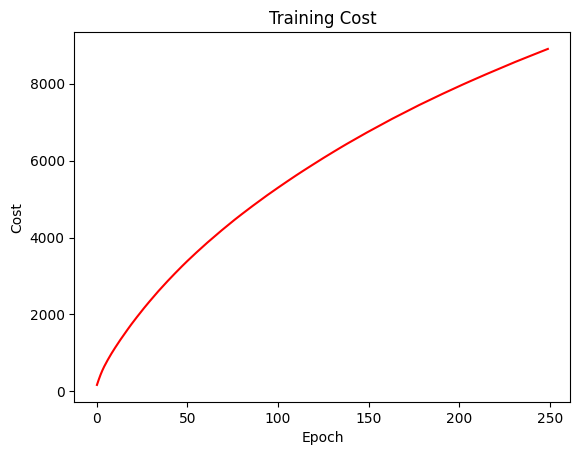

In [74]:

# Compare
fig, ax = plt.subplots()
ax.set(xlabel='Epoch', ylabel='Cost', title="Training Cost")
plt.plot([x for x in range(epochs)], epochLoss, 'red')
plt.show()